In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import logging
import numpy as np
import seaborn as sns
import index_definition
import index_utils as ai
from confidence_index import get_confidence_index
from train_online_model import predict, generate_live_match_data
import warnings
import common
import dill

# 忽略所有警告
warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,  
    format='%(asctime)s [简记] %(message)s',  # 去除非必要字段
    handlers=[
        logging.StreamHandler(), 
        logging.FileHandler('data_analysis.log') 
    ]
)

In [ ]:
#探究信心指数对比赛结果的影响





🚀 Processing: 1386it [00:48, 28.35it/s]                      4.27it/s]


[测试集] 准确率: 30.83% | AUC: -0.00
[测试集] 准确率: 3.33% | AUC: -0.00
[测试集] 准确率: 9.17% | AUC: -0.00
[测试集] 准确率: 2.50% | AUC: -0.00
[测试集] 准确率: 5.83% | AUC: -0.00
[测试集] 准确率: 5.83% | AUC: -0.00
[测试集] 准确率: 3.33% | AUC: -0.00
[测试集] 准确率: 7.50% | AUC: -0.00
[测试集] 准确率: 2.50% | AUC: -0.00
[测试集] 准确率: 72.50% | AUC: -0.00
[测试集] 准确率: 10.83% | AUC: -0.00
[测试集] 准确率: 21.67% | AUC: -0.00
[测试集] 准确率: 81.67% | AUC: -0.00
[测试集] 准确率: 5.83% | AUC: -0.00
[测试集] 准确率: 60.00% | AUC: -0.00
[测试集] 准确率: 2.50% | AUC: -0.00
[测试集] 准确率: 13.33% | AUC: -0.00
[测试集] 准确率: 31.67% | AUC: -0.00
[测试集] 准确率: 20.83% | AUC: -0.00
[测试集] 准确率: 67.50% | AUC: -0.00
[测试集] 准确率: 92.50% | AUC: -0.00
[测试集] 准确率: 4.17% | AUC: -0.00
[测试集] 准确率: 84.17% | AUC: -0.00
[测试集] 准确率: 62.50% | AUC: -0.00
[测试集] 准确率: 60.83% | AUC: -0.00
[测试集] 准确率: 6.67% | AUC: -0.00
[测试集] 准确率: 3.33% | AUC: -0.00
[测试集] 准确率: 99.17% | AUC: -0.00
[测试集] 准确率: 2.50% | AUC: -0.00


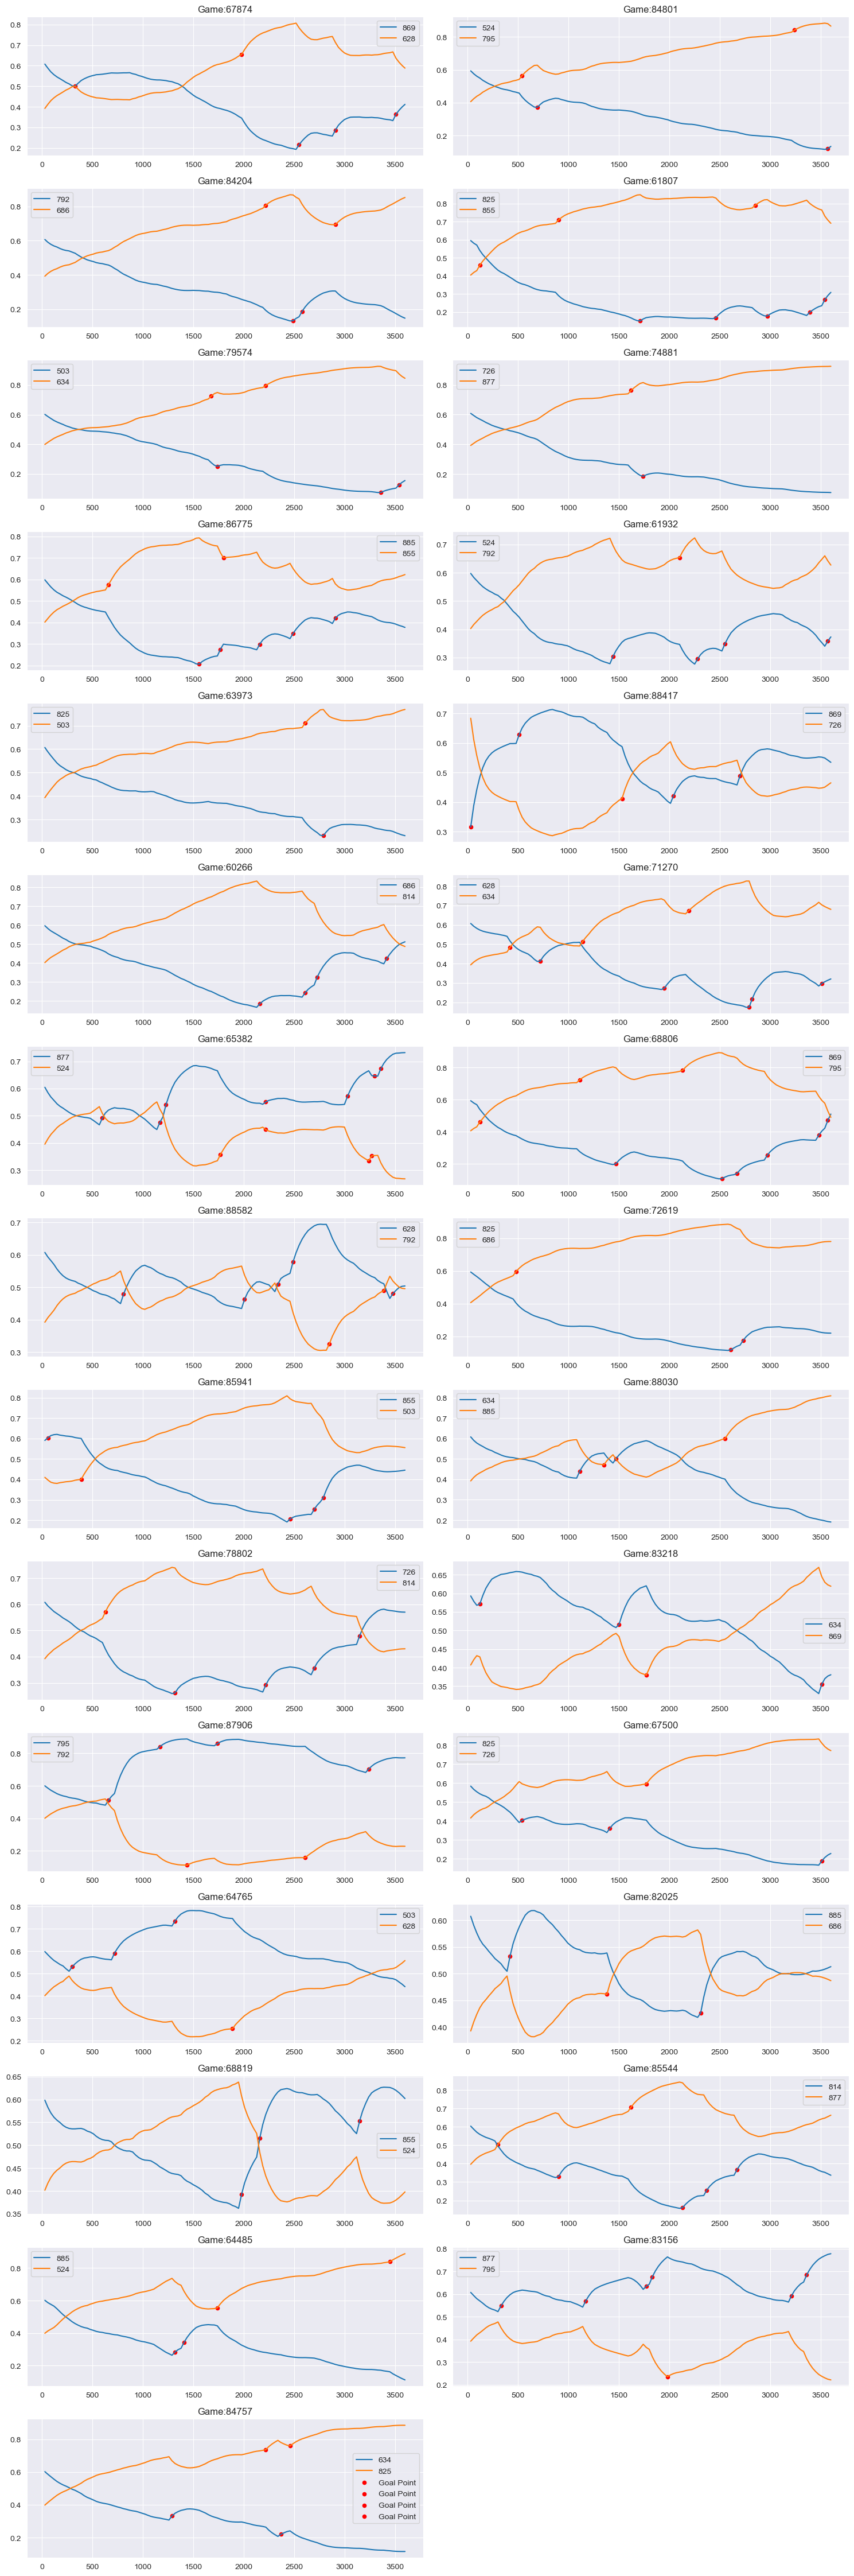

In [3]:
data = pd.read_csv("Linhac24-25_Sportlogiq.csv")
data['inopponentarea'] = data.apply(common.puck_location, axis=1)
gameids = data['gameid'].unique()
test_games = gameids[1:30]
test_data = generate_live_match_data(test_games)
test_data['score_diff'].fillna(method='pad', inplace=True)
with open('trained_model.pkl', 'rb') as f:
    model = dill.load(f)
max_cols = 2 #每行最多显示2张
num_plots = len(test_games)
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
for i in range(len(test_games)):    
    gameid = test_games[i] 
    
    ax = plt.subplot(rows, cols, i + 1)
    winner = common.get_winner(data,gameid)
    winner_goal_times = test_data[(test_data['gameid'] == gameid) & (test_data['teamid'] == winner[0]) &                            (test_data['goal'] == 1)]['elapsed_sec'].values
    fail_goal_times = test_data[(test_data['gameid'] == gameid) & (test_data['teamid'] == winner[1]) &                  (test_data['goal'] == 1)]['elapsed_sec'].values
    
    res = predict(test_data,gameid,winner[0], winner[0], model)
    sns.lineplot(x=list(res['elapsed_sec']), y=list(res['home_win_rate']),label = winner[0], ax=ax)
    sns.lineplot(x=list(res['elapsed_sec']), y=list(res['away_win_rate']),label =  winner[1],ax=ax)
    for goal_time in winner_goal_times:
         ax.scatter(x=goal_time, y=res[res['elapsed_sec'] == goal_time]['home_win_rate'], color='red', marker='o', s=20, label='Goal Point')
    for goal_time in fail_goal_times:
         ax.scatter(x=goal_time, y=res[res['elapsed_sec'] == goal_time]['away_win_rate'], color='red', marker='o', s=20, label='Goal Point')
    ax.set_title('Game:' + str(gameid))
plt.tight_layout()
plt.legend()
plt.show()
    

In [ ]:



#data.to_csv('hockey.csv')

# ai.plot_attack_index_time(data, 60592, 503, index_definition.STRENGTH_EVENTS, 15, 0, 3600)
# ai.plot_attack_index_time(data, 60592, 524, index_definition.STRENGTH_EVENTS, 15, 0, 3600)

In [ ]:
#单独分析比赛 68819
games = [64485,64765,68819]
max_cols = 2 #每行最多显示2张
num_plots = 2 * len(games)
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
for j in range(len(games)):
    gameid  = games[j]
    game_df = data[data['gameid'] == gameid]
    teams = game_df['teamid'].unique()
    for i in range(len(teams)):
        teamid = teams[i]
        team_df = game_df[game_df['teamid'] == teamid]
        res_df = pd.DataFrame()
        for event in index_definition.STRENGTH_EVENTS:
            condition = team_df.eval(event)
            condition_df = team_df[condition]
            res_df = condition_df if res_df.empty else pd.concat([res_df, condition_df],axis=0)
        ax = plt.subplot(rows, cols, i + 2*j + 1)
        plt.subplots_adjust(hspace=1)  # 值在 0 到 1 之间，值越大行间距越大
       # value_counts = res_df['eventname'].value_counts()
       # sns.countplot(x='eventname', data=res_df, order=value_counts.index, palette="viridis",ax=ax)
        value_counts = team_df['eventname'].value_counts()
        sns.countplot(x='eventname', data=team_df, order=value_counts.index, palette="viridis",ax=ax)

        # plt.xticks(rotation=70)
        plt.title('Game {}: Team {}'.format(gameid,teamid))

plt.show()





In [ ]:

games = [64485, 64765,68819,87906]
max_cols = 2  #每行最多显示2张
num_plots = 2 * len(games)
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
for j in range(len(games)):
    gameid = games[j]
    home_control_rate, visit_control_rate, home_max_control_time, visit_max_control_time = common.get_control_rate0(data, gameid)
    print("主队平均控球时间：" + str(sum(home_max_control_time) / len(home_max_control_time)))
    print("客队平均控球时间：" + str(sum(visit_max_control_time) / len(visit_max_control_time)))

    # plt.scatter( x=range(len(home_max_control_time)),y=list(home_max_control_time),marker='o',label='Home Team')
    # plt.scatter(x=range(len(visit_max_control_time)),y=list(visit_max_control_time),marker='x',label='Visit Team')
    ax = plt.subplot(rows, cols, j + 1)
    sns.lineplot(x=range(len(home_max_control_time)), y=list(home_max_control_time), color='r', label='Home Team',
                 ax=ax)
    sns.lineplot(x=range(len(visit_max_control_time)), y=list(visit_max_control_time), color='b', label='Visit Team',
                 ax=ax)
    plt.legend()
    plt.title('Game {}'.format(gameid))
plt.show()
